# Watts–Strogatz Model — Project Notebook

**Goal:** Explain and simulate the Watts–Strogatz small-world network model.  
We will compute and visualize:
- degree distribution,
- average clustering coefficient,
- (approximate) average shortest path length,

and demonstrate the transition from a regular lattice (p=0) to a random network (p=1), showing how **small-world** behavior emerges for small p: high clustering with low path length.

This notebook contains both explanatory markdown cells and runnable Python code.


In [1]:
# Core implementations: Watts-Strogatz generator, clustering, BFS-based distances.
import random
from collections import deque
import math
import numpy as np

def watts_strogatz(n, k, p, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    if k % 2 != 0:
        raise ValueError("k must be even")
    adj = {i:set() for i in range(n)}
    half = k//2
    for i in range(n):
        for j in range(1, half+1):
            nbr = (i + j) % n
            adj[i].add(nbr)
            adj[nbr].add(i)
    for i in range(n):
        for j in range(1, half+1):
            if random.random() < p:
                old = (i + j) % n
                if old in adj[i]:
                    adj[i].remove(old)
                if i in adj[old]:
                    adj[old].remove(i)
                possible = set(range(n)) - {i} - adj[i]
                if not possible:
                    continue
                new = random.choice(list(possible))
                adj[i].add(new)
                adj[new].add(i)
    return adj

def local_clustering(adj, i):
    neighbors = adj[i]
    k_i = len(neighbors)
    if k_i < 2:
        return 0.0
    links = 0
    for u in neighbors:
        for v in neighbors:
            if u < v and v in adj[u]:
                links += 1
    possible = k_i*(k_i-1)/2
    return links/possible

def average_clustering(adj):
    n = len(adj)
    vals = [local_clustering(adj,i) for i in range(n)]
    return sum(vals)/n

def bfs_distances(adj, source):
    n = len(adj)
    dist = {i: None for i in range(n)}
    q = deque([source])
    dist[source] = 0
    while q:
        u = q.popleft()
        for v in adj[u]:
            if dist[v] is None:
                dist[v] = dist[u] + 1
                q.append(v)
    return dist

def avg_shortest_path_length(adj, samples=100):
    n = len(adj)
    nodes = list(range(n))
    if samples >= n:
        sample_nodes = nodes
    else:
        sample_nodes = random.sample(nodes, samples)
    all_distances = []
    for s in sample_nodes:
        dist = bfs_distances(adj, s)
        finite = [d for d in dist.values() if d is not None]
        if len(finite) > 1:
            all_distances.extend(finite)
    if len(all_distances) == 0:
        return float('inf')
    return sum(all_distances)/len(all_distances)


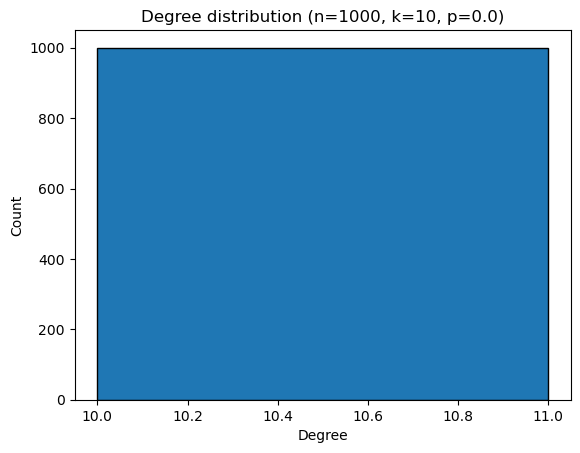

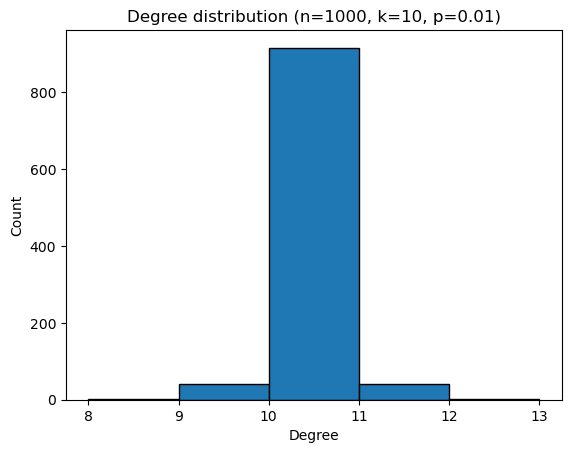

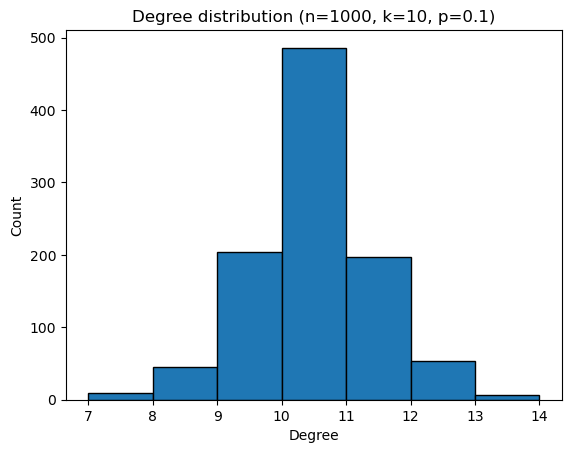

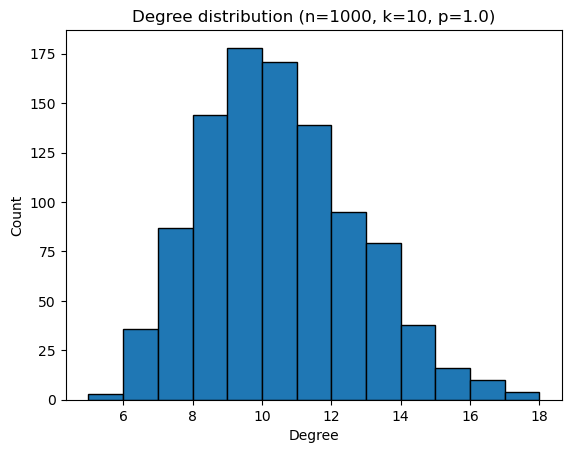

In [2]:
# Example: build graphs with n=1000, k=10 for p in [0.0, 0.01, 0.1, 1.0]
import matplotlib.pyplot as plt

n = 1000
k = 10
ps = [0.0, 0.01, 0.1, 1.0]

sample_degs = {}
for p in ps:
    adj = watts_strogatz(n, k, p, seed=42)
    degs = [len(adj[i]) for i in range(n)]
    sample_degs[p] = degs

for p, degs in sample_degs.items():
    plt.figure()
    plt.hist(degs, bins=range(min(degs), max(degs)+2), edgecolor='black')
    plt.title(f"Degree distribution (n={n}, k={k}, p={p})")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.show()


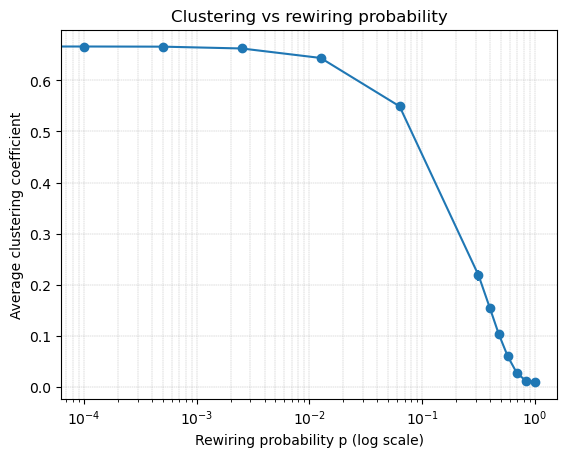

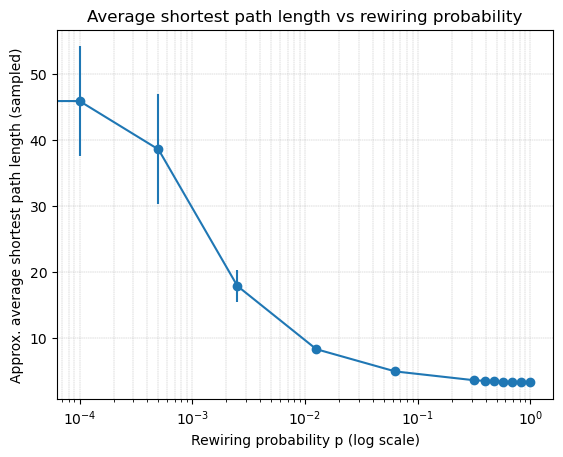

In [3]:
# Sweep over p (rewiring probability) and measure clustering & approx. path length
import numpy as np
import matplotlib.pyplot as plt

n = 1000
k = 10
p_values = np.concatenate(([0.0], np.logspace(-4, -0.5, 6), np.logspace(-0.4, 0, 6), [1.0]))
p_values = np.unique(np.round(p_values, 6))
p_values = np.sort(p_values)

results = []
realizations = 5
samples_for_bfs = 100

for p in p_values:
    cls = []
    apl = []
    for r in range(realizations):
        adj = watts_strogatz(n, k, p, seed=42+r)
        cls.append(average_clustering(adj))
        apl.append(avg_shortest_path_length(adj, samples=samples_for_bfs))
    results.append({
        "p": float(p),
        "clustering_mean": float(np.mean(cls)),
        "clustering_std": float(np.std(cls)),
        "apl_mean": float(np.mean(apl)),
        "apl_std": float(np.std(apl))
    })

# plot
ps = [r["p"] for r in results]
cl_means = [r["clustering_mean"] for r in results]
cl_stds = [r["clustering_std"] for r in results]
apl_means = [r["apl_mean"] for r in results]
apl_stds = [r["apl_std"] for r in results]

plt.figure()
plt.errorbar(ps, cl_means, yerr=cl_stds, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Rewiring probability p (log scale)')
plt.ylabel('Average clustering coefficient')
plt.title('Clustering vs rewiring probability')
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.show()

plt.figure()
plt.errorbar(ps, apl_means, yerr=apl_stds, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Rewiring probability p (log scale)')
plt.ylabel('Approx. average shortest path length (sampled)')
plt.title('Average shortest path length vs rewiring probability')
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.show()


## Network visualization (circle-layout) — explanation and reproduction

This cell shows circle-layout network visualizations for three representative rewiring probabilities:
- **p = 0.0** — the original ring lattice (local connections only).
- **p = 0.01** — a small rewiring value in the small-world regime (few long-range shortcuts).
- **p = 1.0** — fully random rewiring.

The images are generated with `n=200`, `k=6` and saved as:
`network_vis_p_0_0.png`, `network_vis_p_0_01.png`, `network_vis_p_1_0.png`.


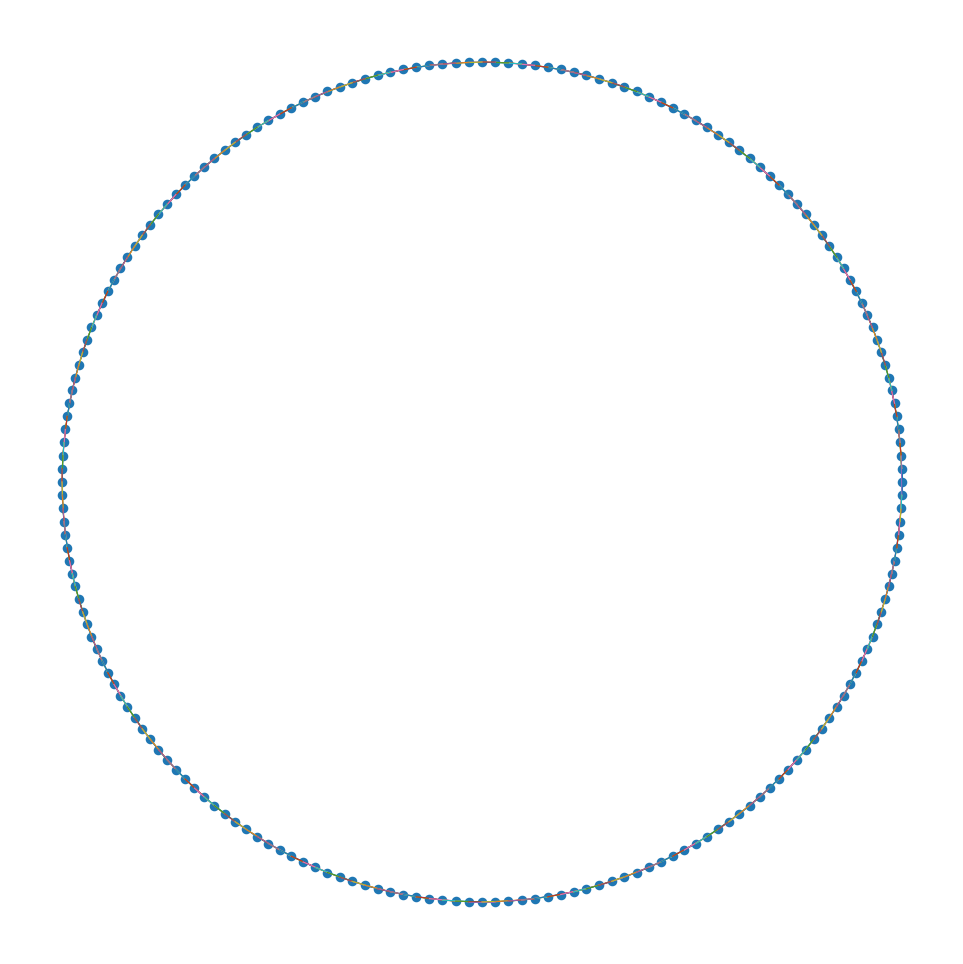

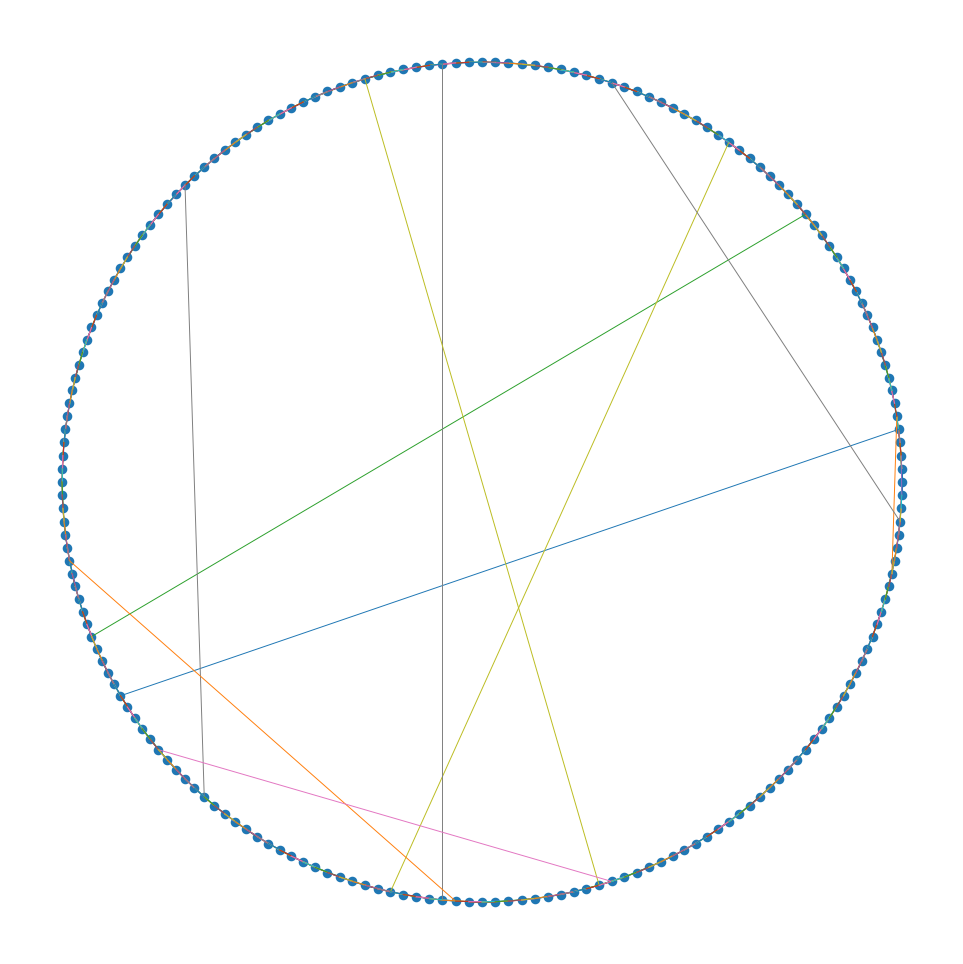

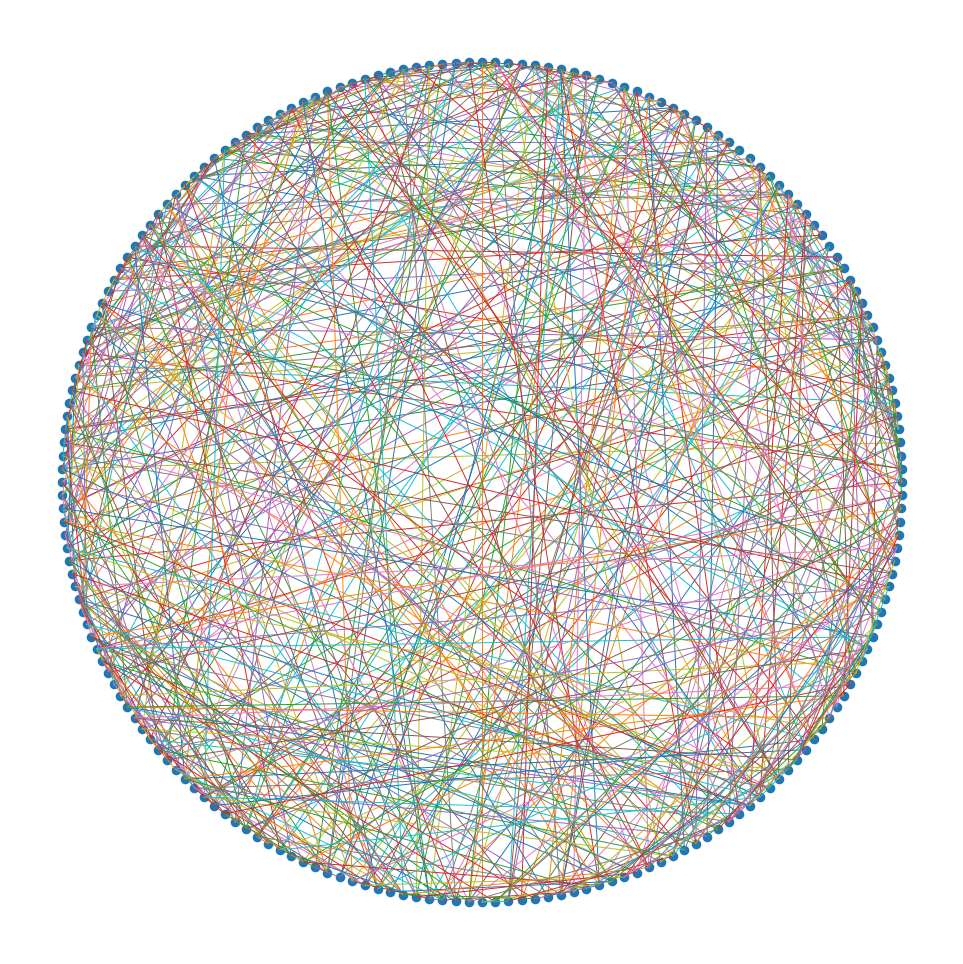

In [5]:
# Generate and plot the circle-layout network visualizations.
import random, math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image

def watts_strogatz(n, k, p, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    adj = {i:set() for i in range(n)}
    half = k//2
    for i in range(n):
        for j in range(1, half+1):
            nbr = (i + j) % n
            adj[i].add(nbr)
            adj[nbr].add(i)
    for i in range(n):
        for j in range(1, half+1):
            if random.random() < p:
                old = (i + j) % n
                if old in adj[i]:
                    adj[i].remove(old)
                if i in adj[old]:
                    adj[old].remove(i)
                possible = set(range(n)) - {i} - adj[i]
                if not possible:
                    continue
                new = random.choice(list(possible))
                adj[i].add(new)
                adj[new].add(i)
    return adj

def draw_and_save(adj, path_out, n):
    theta = np.linspace(0, 2*math.pi, n, endpoint=False)
    coords = [(math.cos(t), math.sin(t)) for t in theta]
    plt.figure(figsize=(6,6))
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.axis('off')
    for i in range(n):
        for j in adj[i]:
            if j > i:
                x1,y1 = coords[i]
                x2,y2 = coords[j]
                ax.plot([x1,x2],[y1,y2], linewidth=0.35)
    xs = [c[0] for c in coords]
    ys = [c[1] for c in coords]
    ax.scatter(xs, ys, s=6)
    plt.savefig(path_out, bbox_inches='tight', dpi=200)
    plt.close()

n_small = 200
k_small = 6
for p in [0.0, 0.01, 1.0]:
    adj = watts_strogatz(n_small, k_small, p, seed=123)
    fname = f"network_vis_p_{str(p).replace('.', '_')}.png"
    draw_and_save(adj, fname, n_small)
    display(Image(filename=fname))


## Interpretation and discussion

The expected and observed behavior in the Watts–Strogatz model:
- **p = 0 (regular lattice):** High clustering (neighbors highly connected) and **large** average path length (long-range connections absent).
- **Small p (e.g., 10^-3–10^-2):** Clustering remains relatively high while average path length **drops dramatically** because a few long-range "shortcuts" reduce distances across the graph — this is the **small-world regime**.
- **p → 1 (random graph):** Clustering becomes low (comparable to Erdős–Rényi random graphs) while path length stays small.

This combination — high clustering like a lattice and short path lengths like a random graph — is the small-world phenomenon Watts & Strogatz described.

